# DRAGON: Determining Regulatory Associations using Graphical models on multi-Omic Networks

Katherine H Shutta <sup>1,2</sup>, Michael Altenbuchinger<sup>3</sup>

<sup>1</sup> Department of Biostatistics, Harvard T.H. Chan School of Public Health, Boston, MA, USA,

<sup>2</sup> Channing Division of Network Medicine, Brigham and Women's Hospital and Harvard Medical School, Boston, MA, USA,

<sup>3</sup> Department of Medical Bioinformatics, University Medical Center Göttingen, Göttingen, Germany

# 1. Introduction

Correlation analysis in often used to find associations between biological entities. However, such analysis can be hampered by spurious correlations, which might be particularly true for high-dimensional multi-omic data. DRAGON<sup>1</sup> attempts to address this question by computing partial correlations between variables across two (omics-)layers. 

In this vignette, we will first generate synthetic data comprising two omics layers, then estimate the regularization parameters, and finally estimate partial correlations between the variables represented in each of the two layers and compute the corresponding significance levels.

# 2. Load DRAGON
We first load DRAGON functions from netZooPy (> v0.9). If you need to install netZooPy, please refer to the [installation guide](https://github.com/netZoo/netZooPy/blob/master/README.md).

In [1]:
from netZooPy.dragon import *      # To load DRAGON
import matplotlib.pyplot as plt    # To load plotting functions
import numpy as np                 # To generate synthetic data
from mpl_toolkits.mplot3d import Axes3D, art3d # To regularization landscape

# 3. Simulate data with two omics layers
To start, we use `simulate_dragon_data` to simulate multi-omics data. Here, `p1` and `p2` refers to the number of variables in omics layer 1 and 2, respectively. The proportion of edges within layer 1 and 2 is set by `eta11` and `eta22`, respectively, and the proportion of edges which connect variables from layer 1 with variables from layer 2 is `eta12`. The sample size is given by `n`, the noise by `epsilon`, and the seed by `seed`.

In [2]:
n = 1000
p1 = 500
p2 = 100

After setting the parameters, we can simulate the two data sets

In [3]:
X1, X2, Theta, _ = simulate_dragon_data(eta11=0.005, eta12=0.005, eta22=0.05,
                                        p1=p1, p2=p2, epsilon=[0.1,0.1],
                                        n=n, seed=123)

n11=624, n12=250, n22=248


This returns data from omics layer 1, `X1`, and from layer 2, `X2`, with n measurements in the rows and with p1 and p2 variables in the columns. Theta corresponds to the underlying, true precision matrix. We first standardize the variables (DRAGON was verified for standardized data) and verify the dimensions of `X1` and `X2`:

In [4]:
X1 = Scale(X1)
X2 = Scale(X2)
print(X1.shape)
print(X2.shape)

(1000, 500)
(1000, 100)


# 4. Regularization
## Estimate regularization
DRAGON uses an efficient way to estimate regularization parameters for each data set:

In [5]:
lambdas, lambdas_landscape = estimate_penalty_parameters_dragon(X1, X2)
print(lambdas)

(0.8231058681549138, 0.7162464690265522)


## Plot regularization landscape
We can also visualize the regularization landscape as follows.

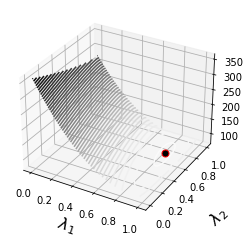

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.arange(0,1.01,0.01)
ax.contour3D(x, x, lambdas_landscape, 50, cmap='binary')
ind = np.unravel_index(np.argmin(lambdas_landscape, axis=None),
                       lambdas_landscape.shape)
ax.plot([x[int(ind[1])]], [x[int(ind[0])]],
       [lambdas_landscape[int(ind[0]),int(ind[1])]],
       markerfacecolor='k', markeredgecolor='r', marker='o',
       markersize=7, alpha=1)
ax.set_xlabel('$\lambda_1$', fontsize=16)
ax.set_ylabel('$\lambda_2$', labelpad=15, fontsize=16)
plt.show()

# 5. Estimate the DRAGON-regularized partial correlation matrix
Next, we estimate shrunken partial correlations using the regularization parameters determined above.

In [7]:
r = get_partial_correlation_dragon(X1, X2, lambdas)
r.shape

(600, 600)

`r` contains partial correlations between each of the variables in our data. Since we have 500 variables in `X1` and 100 variables in `X2`, `r` has a size of 600 by 600.

# 6. Assign significance levels
Finally, we assign significance levels by computing p-values. Here, we need to correctly specify the number of samples `n`, the number of variables `p1` and `p2` corresponding to `X1` and `X2`, respectively, and we have to use exactly the values `lambdas` that we used to estimate r.

In [8]:
adj_p_vals, p_vals = estimate_p_values_dragon(r, n, p1, p2, lambdas)

kappa estimate (k11, k22, k12): [1182.472731589413, 1153.4888064307424, 1164.3444259685855]


`p_vals` contains the p-values for the associations found in `r` and `adj_p_vals` the corresponding FDR adjusted p-values for multiple testing.

We can visualize the original precision matrix by

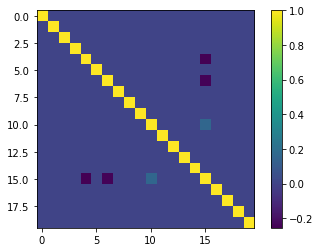

In [9]:
plt.imshow(Theta[0:20,0:20])
plt.colorbar()
plt.show()

and the significance levels of estimated edges by

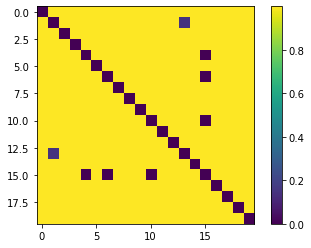

In [10]:
plt.imshow(adj_p_vals[0:20,0:20])
plt.colorbar()
plt.show()

This can tell us both about the magnitude of association as given by the partial correlations (`r`), and their significance (`adj_p_vals`).

# References

1- Shutta, Katherine H, et al. "DRAGON: Determining Regulatory Associations using Graphical models on multi-Omic Networks", Nucleic Acids Research (2022): gkac1157, https://doi.org/10.1093/nar/gkac1157

2- Altenbuchinger, Michael, et al. "Gaussian and Mixed Graphical Models as (multi-) omics data analysis tools." Biochimica et Biophysica Acta (BBA)-Gene Regulatory Mechanisms 1863.6 (2020): 194418.